In [480]:
# Import necessary libraries:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import scikitplot as skplt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp

In [400]:
# Load two datasets (training and testing):
au_train = pd.read_csv('au_train.csv')
au_test = pd.read_csv('au_test.csv')

# 1. Data Preprocessing:

In [401]:
# Call Label Encoder:
le = LabelEncoder()

In [402]:
# Define a function to preprocess two datasets. Most categorical variables in this problem have many levels.
# There are at least three ways to deal with this problem: (1) Label/one-hot encode, (2) Frequency encode, (3) Target (Mean)
# econde. There is not so much time, so I would exploit the observation from data segmentation to map features based on
# the similar class ratio (cluster encode):
def preprocess(dataset):
    # Label encode class, sex, and race features:
    dataset['class'] = le.fit_transform(dataset['class'])
    dataset['sex'] = le.fit_transform(dataset['sex'])
    dataset['race'] = le.fit_transform(dataset['race'])
    # As shown in the visualization of segments, wife and husband have fairly balanced class 0 and 1 ratio, so they can be
    # mapped into one group:
    dataset['relationship'] = dataset['relationship'].map({' Wife': 3,
                                                           ' Husband': 3,
                                                           ' Other-relative': 2,
                                                           ' Own-child': 1})
    dataset['relationship'] = dataset['relationship'].fillna(0)
    # Here, I map education level based on the common sense (and also segmentation). Bachelors and Doctorates are much more
    # often to by in class 1, particularly Doctorates:
    dataset['education'] = dataset['education'].map({' Bachelors': 2,
                                                   ' Masters': 3,
                                                   ' Some-college': 2,
                                                   ' HS-grad': 1,
                                                   ' Assoc-acdm': 1,
                                                   ' Assoc-voc': 1,
                                                   ' Doctorate': 3,
                                                   ' Prof-school': 1})
    dataset['education'] = dataset['education'].fillna(0)
    # Married verus single:
    dataset['marital-status'] = dataset['marital-status'].map({' Married-civ-spouse': 1})
    dataset['marital-status'] = dataset['marital-status'].fillna(0)
    # USA, Mexico, versus other countries. Here we can also code levels based on frequency. I tried but it does not help as ex
    # expected:
    dataset['native-country'] = dataset['native-country'].map({' United-States': 3,
                                                            ' Mexico': 2,
                                                            ' ?': 1})
    dataset['native-country'] = dataset['native-country'].fillna(0)
    # Never-work and work with out pay are pretty much the same (class ratio and meaning), so are state, local, and federal governmental jobs:
    dataset['workclass'] = dataset['workclass'].map({' Private': 4,
                                                  ' ?': 3,
                                                  ' Never-work': 2,
                                                  ' Without-pay': 2,
                                                  ' Self-emp-inc': 1,
                                                  ' Self-emp-not-inc': 1})
    dataset['workclass'] = dataset['workclass'].fillna(0)
    # Label encode occupation:
    dataset['occupation'] = le.fit_transform(dataset['occupation'])
                                                                 
    return dataset

In [403]:
# Preprocess datasets:
au_train = preprocess(au_train)
au_test = preprocess(au_test)

# 2. Baseline Model:

In [406]:
# Prepare X_train, X_test, y_train, y_test to train the classifier:
X_train = au_train.drop(['class'], axis=1)
y_train = au_train[['class']]
X_test = au_test.drop(['class'], axis=1)
y_test = au_test[['class']]

In [407]:
# There are many categorical variables, plus decision tree classiifier works fairly well with binary classification,
# let's use it as the baseline model.
# Pre-prune the tree to prevent overfitting:
clf_base = DecisionTreeClassifier(max_depth = 10)

In [410]:
# Fit the training data to train the classifier. Predict and check out how it works on testing data:
clf_base.fit(X_train, y_train)
p_1 = clf_base.predict(X_test)
print(accuracy_score(y_test, p_1))

0.855352865303


Accuracy = 0.855 is not bad at all!

C:\Users\Lee TyT\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


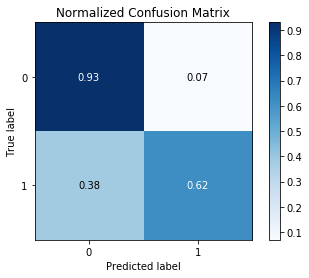

In [492]:
# For imbalanced dataset, it is helpful to examine true-positive rate:
skplt.metrics.plot_confusion_matrix(y_test, p_1, normalize=True)

As expected, the classifier yields only 0.62 true positive rate. It's a decent point, but it might be improved.

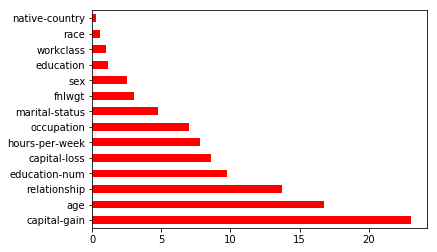

In [456]:
# Check out the most important features. It might be helpful to prune some that are not too important:
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh', color='r')

Native country is the least important, which is not toop surprising because the census is of American citizens mostly. Let's get rid of this variable and seeif it helps!

# 3. Boosting Models:

# 3.1 Gradient Boosting Classifier:

In [493]:
# I first train the gradient boosting classifier on only train dataset and use cross validation to check if there's overfitting:

# Split au_train into X and y:
X = au_train.drop(['class', 'native-country'], axis=1)
y = au_train[['class']]

# Instatiate Gradient Boosting Classifier:
gbc = GradientBoostingClassifier(learning_rate=0.9, random_state=43)

In [494]:
# Use StratifiedKFold to split the data into 5 folds preserving original class ratio:
skf = StratifiedKFold(n_splits=5)

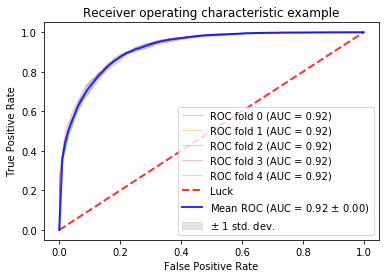

In [460]:
# Plot the ROC AUC curve of five cross validation folds (source code: sklearn library):
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in skf.split(X, y):
    # Fit and predict probas with gbc after splitting the dataset into 5 folds:
    probas_ = gbc.fit(X.iloc[train], y.iloc[train].values.ravel()).predict_proba(X.iloc[test])
    fpr, tpr, thresholds = roc_curve(y.iloc[test].values.ravel(), probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

0.92 is a really high value of ROC index (AUC) indicating the classifier is performing well over different thresholds. ROC index is also consistent
over 5 folds indicates there might not be any overfitting.

In [490]:
# Check the accuracy score of gradient boosting classifier over 5 folds:
gbc_accuracy = []
for train, test in skf.split(X, y):
    p = gbc.fit(X.iloc[train], y.iloc[train].values.ravel()).predict(X.iloc[test])
    gbc_accuracy.append(accuracy_score(p, y.iloc[test]))
    print(gbc_accuracy)

[0.85751573775525869]
[0.85751573775525869, 0.86348280098280095]
[0.85751573775525869, 0.86348280098280095, 0.85979729729729726]
[0.85751573775525869, 0.86348280098280095, 0.85979729729729726, 0.86885749385749389]
[0.85751573775525869, 0.86348280098280095, 0.85979729729729726, 0.86885749385749389, 0.86609336609336607]


The classifier does well on all 5 folds. We can be more certain that it won't overfit here!

In [469]:
# Use gradient boost classifier to predict y_test in test dataset:
gbc.fit(X_train, y_train.values.ravel())
p_2 = gbc.predict(X_test)

In [470]:
# Check if gradient boost improves our result:
accuracy_score(y_test, p_2)

0.86696148885203617

It beats the baseline decision tree model by 0.01 accuracy point!

C:\Users\Lee TyT\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


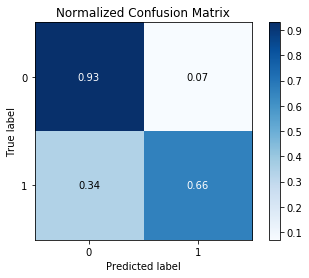

In [471]:
# Plot the confusion matrix to see how the classifier is doing with true positive rate:
skplt.metrics.plot_confusion_matrix(y_test, p_2, normalize=True)

It beats the baseline classifer by 0.04 point. Though 0.66 is not too spectacular of a true positive rate, the model improves the baseline's result a lot.
Very often, in an imbalanced dataset, true positive rate decreases as accuracy score increases. In this case, the gradient boost classifier imporves both metrics.

# 3.2 CatBoost Classifier:

In [488]:
# The dataset has a lot of categorical variables with many different levels. I have tried label and frequency encoding yet
# haven't implemented mean/target encoding. Target encoding with smoothing regularition is built in cat boost classifier.
# Hence, let's try to implement catboost and optimize its parameters with GridSearch here:

# Instantiate catboost classifier:
cb = CatBoostClassifier()

# Call parameter lists:
param_grid = dict(iterations = range(10, 50, 5), learning_rate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Search for the best combination (highest accuracy score):
grid = GridSearchCV(cb, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

0:	learn: 0.5984581	total: 94.9ms	remaining: 854ms
1:	learn: 0.5351399	total: 184ms	remaining: 736ms
2:	learn: 0.4862273	total: 270ms	remaining: 629ms
3:	learn: 0.4421859	total: 379ms	remaining: 569ms
4:	learn: 0.4127646	total: 465ms	remaining: 465ms
5:	learn: 0.3901646	total: 552ms	remaining: 368ms
6:	learn: 0.3740530	total: 662ms	remaining: 284ms
7:	learn: 0.3629655	total: 752ms	remaining: 188ms
8:	learn: 0.3530628	total: 839ms	remaining: 93.3ms
9:	learn: 0.3446414	total: 946ms	remaining: 0us
0:	learn: 0.5898363	total: 117ms	remaining: 1.06s
1:	learn: 0.5226456	total: 204ms	remaining: 816ms
2:	learn: 0.4688841	total: 299ms	remaining: 699ms
3:	learn: 0.4325617	total: 404ms	remaining: 606ms
4:	learn: 0.4046674	total: 492ms	remaining: 492ms
5:	learn: 0.3849850	total: 597ms	remaining: 398ms
6:	learn: 0.3707522	total: 685ms	remaining: 294ms
7:	learn: 0.3596839	total: 790ms	remaining: 197ms
8:	learn: 0.3502202	total: 881ms	remaining: 97.9ms
9:	learn: 0.3443526	total: 953ms	remaining: 0us
0

KeyboardInterrupt: 